In [3]:
import matplotlib.pyplot as plt
import wrapper_for_data as wrap
import analysis_for_data as analysis
import exponential_median as exp_median
import noise_addition_for_smooth_sens as ss_median
import binary_search_median as bisearch_median
import cdf_median as cdf_median
import bs_cdf_median
import grad_descent_median as gd_median
import publicCI as pub
import run_CI_algs as run_cis
import imp
import common
import numpy as np
import scipy.stats as st

Notes on running this notebook:

1. You have to make empty folders called "data", "analysis", and "results" before running it.
2. The first time you run it, you need the gen_preprocess flag in the calls to runCIAlgs etc to be set to True. This runs the (time intensive) pre-processing and creates those files. Otherwise, the functions expect them. In order to save time if rerunning, you can flip this flag to False.
3. If in the plot generation code you are setting save=True, you also will need a "fig" folder, and will need to add the subfolders in that are stated in the save path. Alternatively, you can set this flag to false and the figures will not be saved.
4. The run_indices flag is used to list the algorithms that will be included in the final plot. If, for instance, the actual data for that particular algorithm hasn't been run yet, then this will fail. 

In order to test things or modify them, you can always subset the total amount of runs and data used in order to minimize runtime. 


In [4]:
imp.reload(wrap)
imp.reload(analysis)
imp.reload(common)
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(cdf_median)
imp.reload(bisearch_median)
imp.reload(bs_cdf_median)

<module 'bs_cdf_median' from '/Users/ira/Desktop/dp-medians/bs_cdf_median.py'>

In [5]:
# Common for running/plotting
alg_index = [('Expmedian_naive','ExpMechUnion'), #0
             ('Expmedian','ExpMech'), #1
             ('CDFmedian_naive', 'CDFPostProcessUnion'), #2
             ('CDFmedian', 'CDFPostProcess'), #3
             ('CDFBSmedian', 'CDF+BinSearch'), #4
             ('AdaBSCDFmedian', 'BinSearch+CDF'), #5
             ('BSmedian_sep_reuse_queries', 'BinSearch'), #6
             ('AdaBSmedian_sep', 'NoisyBinSearch'), #7
             ('Nonpriv_lognormal', 'Nonprivate Lognormal'), #8  
             ('', 'Nonprivate Nonparametric')] #9

# Eg. set of all algorithms
all_indices = [i for i in range(len(alg_index))]
algs_all = [alg_index[i][0] for i in all_indices[:-1]]
alg_names_all = [alg_index[i][1] for i in all_indices]
print(algs_all)
print(alg_names_all)

# Colors 
colors = ['magenta',
          'indianred',
          'orange',
          'pink',
          'yellow',
          'darkseagreen',
          'skyblue',
          'mediumpurple',
          'aquamarine', # change this?
          'darkslategray']
colors_all = [colors[i] for i in range(len(all_indices))]
print(colors_all)

# Styles
# -.^ --o :v -.* -.
# '///' '--', '...','\///', 'xxx', '\\\\'
styles=[{'color':'magenta', 'linestyle':'-', 'marker':'^', 'hatch':'++'}, #n
        {'color':'indianred', 'linestyle':'-.', 'marker':'^', 'hatch':'///'}, #
        {'color':'orange', 'linestyle':'-', 'marker':'o', 'hatch':'**'}, #n
        {'color':'pink', 'linestyle':'--', 'marker':'o', 'hatch':'--'}, #
        {'color':'yellow', 'linestyle':'-', 'marker':'^', 'hatch':'///'},
        {'color':'darkseagreen', 'linestyle':':', 'marker':'v', 'hatch':'...'}, #
        {'color':'skyblue', 'linestyle':'-', 'marker':'^', 'hatch':'///'},
        {'color':'mediumpurple', 'linestyle':'-.', 'marker':'*', 'hatch':'xxx'}, #
        {'color':'aquamarine', 'linestyle':'-.', 'marker':'^', 'hatch':'++'}, # change this?
        {'color':'darkslategray', 'linestyle':'-', 'marker':'.', 'hatch':'\\\\'} #
       ]
styles_all = [styles[i] for i in range(len(all_indices))]
print(styles_all)


# Save directory
dir_path = 'figs'

# Create save paths for figures
def conf_str(alpha):
    if (type(alpha) is list) or (type(alpha) is np.ndarray):
        return 'alpha'
    else:
        return str(int(100-100*alpha))

def coverage_save_paths(dir_path, dataset_name, param_string, alpha): # revised):
    # Coverage for all algs
    save_path1 = '%s/coverage-%s/coverage-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Coverage for main body algs
    save_path2 = '%s/coverage-%s/coverage-%s-%s-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Coverage for naive vs. new algs
    save_path3 = '%s/coverage-%s/coverage-%s-%s-naive-v-new-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_paths = [save_path1, save_path2, save_path3]
    return save_paths

def width_save_paths(dir_path, dataset_name, param_string, alpha):
    # Relative widths for all algs
    save_path1 = '%s/widths-%s/rel-width-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_path2 = '%s/widths-%s/rel-width-boxplots-%s-%s-all-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Widths for all algs
    save_path3 = '%s/widths-%s/width-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_path4 = '%s/widths-%s/width-boxplots-%s-%s-all-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    # Relative widths for main body algs
    save_path5 = '%s/widths-%s/rel-width-%s-%s-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_path6 = '%s/widths-%s/rel-width-boxplots-%s-%s-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)    
    # Relative widths for naive vs. new algs
    save_path7 = '%s/widths-%s/rel-width-boxplots-%s-%s-naive-v-new-revised-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
    save_paths = [save_path1, save_path2, save_path3, save_path4, save_path5, save_path6, save_path7]
    return save_paths

def legend_save_path(dir_path, algs, plot_type, color):
    # algs = 'main' or 'naive-v-new', plot_type = 'line' or 'box', color = 'color' or 'blackwhite'   
    # blackwhite means readable in black and white, aka textured but can also have color
    save_path = '%s/%s_%s_%s-revised-labels.pdf' % (dir_path, algs, plot_type, color)
    return save_path

['Expmedian_naive', 'Expmedian', 'CDFmedian_naive', 'CDFmedian', 'CDFBSmedian', 'AdaBSCDFmedian', 'BSmedian_sep_reuse_queries', 'AdaBSmedian_sep', 'Nonpriv_lognormal']
['ExpMechUnion', 'ExpMech', 'CDFPostProcessUnion', 'CDFPostProcess', 'CDF+BinSearch', 'BinSearch+CDF', 'BinSearch', 'NoisyBinSearch', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
['magenta', 'indianred', 'orange', 'pink', 'yellow', 'darkseagreen', 'skyblue', 'mediumpurple', 'aquamarine', 'darkslategray']
[{'color': 'magenta', 'linestyle': '-', 'marker': '^', 'hatch': '++'}, {'color': 'indianred', 'linestyle': '-.', 'marker': '^', 'hatch': '///'}, {'color': 'orange', 'linestyle': '-', 'marker': 'o', 'hatch': '**'}, {'color': 'pink', 'linestyle': '--', 'marker': 'o', 'hatch': '--'}, {'color': 'yellow', 'linestyle': '-', 'marker': '^', 'hatch': '///'}, {'color': 'darkseagreen', 'linestyle': ':', 'marker': 'v', 'hatch': '...'}, {'color': 'skyblue', 'linestyle': '-', 'marker': '^', 'hatch': '///'}, {'color': 'mediumpur

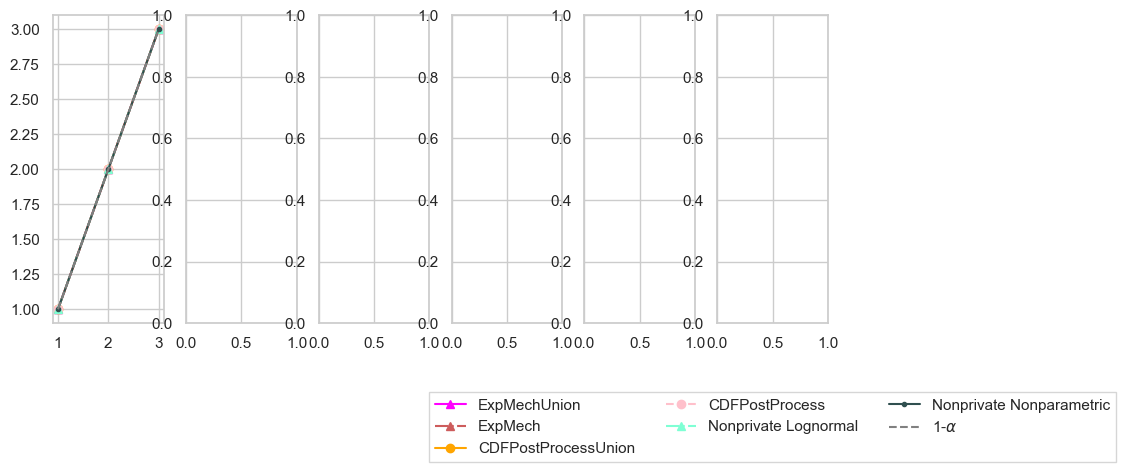

In [6]:
# Legend for line plots
fig, ax = plt.subplots(1, 6, figsize=(10,4))
x =  [1, 2, 3]
y1 = [1, 2, 3]

legend_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in legend_indices_names]
alg_colors = [colors[i] for i in legend_indices_names]
alg_styles = [styles[i] for i in legend_indices_names]

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
handles = []
for i in range(len(alg_names)):
    line = ax[0].plot(x, y1, linestyle=alg_styles[i]['linestyle'], marker=alg_styles[i]['marker'], c=alg_styles[i]['color'], label=alg_names[i])[0]
    handles.append(line)
    
baseline_name = r'1-$\alpha$'
alg_names.append(baseline_name)
baseline = ax[0].plot(x, y1, linestyle='--', marker='', c='gray', label=baseline_name)[0]
handles.append(baseline)

# Create and save the legend
legend = plt.legend(handles = handles, labels=alg_names, loc='upper center', 
             bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=3)
save_path = legend_save_path(dir_path, 'naive-v-new', 'line_plot', 'blackwhite')
# analysis.export_legend(legend, save_path)

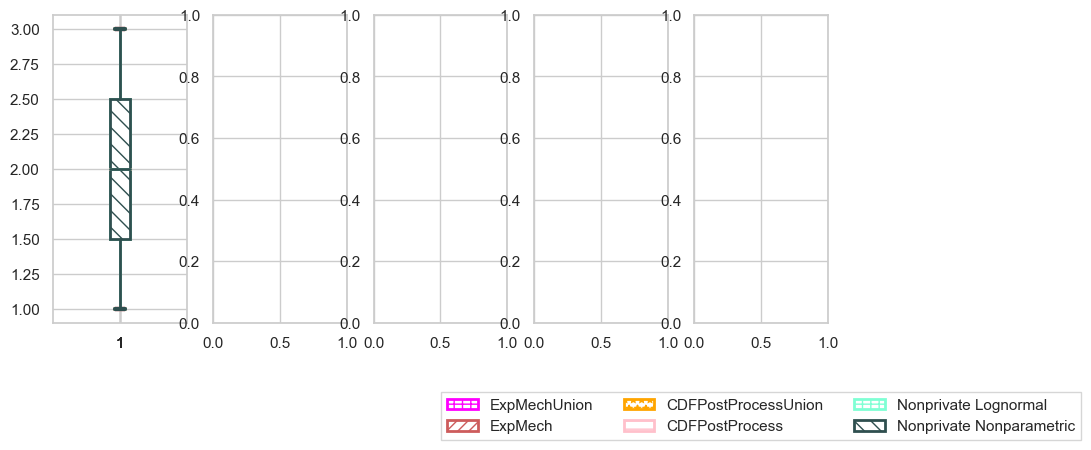

In [5]:
# Legend for box plots
fig, ax = plt.subplots(1, 5, figsize=(10,4))
x =  [1, 2, 3]
y1 = [1, 2, 3]

legend_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in legend_indices_names]
alg_colors = [colors[i] for i in legend_indices_names]
alg_styles = [styles[i] for i in legend_indices_names]

# Create the sub-plots, assigning a different color for each line.
# Also store the line objects created
handles = []
for i in range(len(alg_names)):
    bp = ax[0].boxplot(y1, patch_artist=True)
    hatch = alg_styles[i]['hatch']
    fill_color = 'white'
    outline_color = alg_styles[i]['color']
    
    plt.setp(bp['caps'], color=outline_color, linewidth=3.0, linestyle='-')
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians']:
        plt.setp(bp[element], color=outline_color, linewidth=2.0)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)  
        patch.set(hatch=hatch, edgecolor=outline_color)
    handles.append(bp['boxes'][0])

# Create the legend
legend = plt.legend(handles = handles, labels=alg_names, loc='upper center', 
             bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=3)
save_path = legend_save_path(dir_path, 'naive-v-new', 'box_plot', 'blackwhite')
# analysis.export_legend(legend, save_path)

##  Baseline lognormal data 

In [ ]:
# Baseline data for widths 
# Only use this data when parameter is not part of data
# Otherwise, use lognormal_v1 for varying n and lognormal_v2 for varying data_scale
dataset_name='lognormal_v0'
data_center = 0.5
data_scale = 1.0
n = int(1000)
num_datasets = 1000

for j in range(num_datasets):
    dataset = np.array(st.lognorm.rvs(data_scale, loc=data_center, size=n))
    save_path = 'data/%s_%s.npy' % (dataset_name, str(j))
    np.save(save_path, dataset)
    
true_median = st.lognorm.median(data_scale, loc=data_center)
print(true_median)

In [ ]:
# Baseline data for coverage 
# Not used for comparing widths
dataset_name='lognormal_cov'
data_center = 0.5
data_scale = 1.0
n = int(1000)
num_datasets = 10000 # 10,000 datasets to reduce Monte Carlo error

for j in range(num_datasets):
    dataset = np.array(st.lognorm.rvs(data_scale, loc=data_center, size=n))
    save_path = 'data/%s_%s.npy' % (dataset_name, str(j))
    np.save(save_path, dataset)
    
true_median = st.lognorm.median(data_scale, loc=data_center)

In [ ]:
# Some coverage plots use flatter dist
# May use this data to compare on widths
dataset_name='lognormal_flat'
data_center = 0.5
data_scale = 5.0
n = int(1000)
num_datasets = 10000 # 10,000 datasets to reduce Monte Carlo error

for j in range(num_datasets):
    dataset = np.array(st.lognorm.rvs(data_scale, loc=data_center, size=n))
    print(np.median(dataset))
    save_path = 'data/%s_%s.npy' % (dataset_name, str(j))
    np.save(save_path, dataset)
    
true_median = st.lognorm.median(data_scale, loc=data_center)

# Coverage - varying beta

In [ ]:
num_trials = 5
range_center = 5
range_scale = 10 
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005

dataset_name='lognormal_cov'
n = 1000
num_datasets = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print(true_median)
print(st.lognorm.mean(data_scale, loc=data_center))

beta = [0.01, 0.05, 0.09, 0.13, 0.17]
num_params = len(beta)
param_string='beta'
print(param_string, beta)

In [ ]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(pub)

# Change array of indices on which algorithms you want to run. 
# Note that the nonprivate alg (#9) will be automatically computed along with the last index in the array.
run_indices = [1, 3, 5, 7, 8] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)
# If you have already run the algorithms and just want to do the analysis of their widths/coverage, 
# set rerun_algs to False. 
# If you need to rerun proprocessing for the CDF algorithms, set gen_preprocess to True. 
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, rerun_algs=True, gen_preprocess=True)

In [ ]:
imp.reload(analysis)

run_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
alg_colors = [colors[i] for i in run_indices_names]
print(alg_names)
title = r"Varying $\beta_2$ (P=LN(ln(%.1f),%.1f), $n$=%s, $\alpha$=%.2f, $\rho$=%s, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, n, alpha, rho, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\beta_2$"
# save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

# save_path = save_paths[0] #'%s/coverage-%s/coverage-%s-%s-all-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)
# plt = analysis.plotCIs(algs, dataset_name, title, beta, xlabel, 
#           alg_names, param_string=param_string, ratio=False, alpha=alpha, T=num_trials*num_datasets, n=n,
#           log=False, legend_out=False, xlim=None, ylim=[0.75, 1.05], sort='byParam', coverage=True, 
#             save=True, save_path=save_path, colors=alg_colors)

run_indices = [1, 3, 5, 7, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 5, 7, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
alg_colors = [colors[i] for i in run_indices_names]
print(alg_names)
# save_path = '%s/coverage-%s/coverage-%s-%s-varying-%s.pdf' % (dir_path, param_string, conf_str(alpha), dataset_name, param_string)

save_path = None
plt = analysis.plotCIs(algs, dataset_name, title, beta, xlabel, 
          alg_names, param_string='beta', ratio=False, alpha=alpha, T=num_trials*num_datasets, n=n,
          log=False, legend=False, legend_out=False, xlim=None, ylim=[0, 1], sort='byParam', coverage=True, 
            save=False, save_path=save_path, colors=alg_colors)

# Coverage - varying rho (Figure 3a)

In [ ]:
# dataset_name='lognormal_flat'
# num_datasets = 1000
# n = 1000
# data_center = 0.5
# data_scale = 1.0
# true_median = st.lognorm.median(data_scale, loc=data_center)
# print("true median:", true_median)

dataset_name='lognormal_flat'
num_datasets = 1000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

num_trials = 1
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.5
granularity = 0.01
em_granularity = 0.005

rho = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
num_params = len(rho)
print(rho)
print(granularity)
param_string='rho'

In [ ]:
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(bisearch_median)
imp.reload(pub)
imp.reload(common)

run_indices = [1, 3, 8] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)

run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  rerun_algs=True, gen_preprocess=True, start_param=0)

In [ ]:
imp.reload(analysis)

title = r"Varying $\rho$ (P=LN(ln(%.1f),%.1f), $n$=%s, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, n, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\rho$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save=False
save_path = save_paths[1]
plt = analysis.plotCIs(algs, dataset_name, title, rho, xlabel, alg_names, alpha=alpha,
            param_string=param_string, ratio=False, T=num_trials*num_datasets, n=n, show_title=False,
          log=False, xlog=True, legend_out=False, legend=False, xlim=None, ylim=[0.78, 1.02], sort='byParam', coverage=True, 
            save=save, save_path=save_path, colors=alg_colors, styles=alg_styles, blackwhite=True)

# Coverage - varying n

In [ ]:
dataset_name='lognormal_v3'
num_datasets = 1000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

num_trials = 1
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.5
granularity = 0.01
em_granularity = 0.005

param_string = 'n'
n = [100.,  450.,  800., 1150., 1500., 1850., 5000]
num_params = len(n)
print(param_string, n)

In [ ]:
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(common)

run_indices = [1, 3, 8] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)

run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=True, start_param=0)

In [ ]:
imp.reload(analysis)

title = r"Varying $n$ (P=LN(ln(%.1f),%.1f), $\rho$=%.2f, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$n$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save=True
save_path = save_paths[1]
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names, alpha=alpha,
            param_string=param_string, ratio=False, T=num_trials*num_datasets, n=n, show_title=False,
          log=False, legend_out=False, legend=False, xlim=None, ylim=[0.75, 1.05], sort='byParam', 
                       dataset_param=True, coverage=True, 
            save=save, save_path=save_path, colors=alg_colors, styles=alg_styles, blackwhite=True)

# Coverage - varying n - v4 (Figure 4b)

In [ ]:
dataset_name='lognormal_v4'
num_datasets = 1000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

num_trials = 5
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.2
beta = 0.01
quantile = 0.1
granularity = 0.005
em_granularity = 0.005

param_string = 'n'
n = [100.,  500., 1000., 5000, 10000, 50000]
#n = [5,6]
num_params = len(n)
print(param_string, n)

In [ ]:
imp.reload(run_cis)
imp.reload(exp_median)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(common)
imp.reload(pub)

run_indices = [1, 3, 8, 9] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)

run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=True, start_param=0)

In [ ]:
imp.reload(analysis)

title = "foo" # r"Varying $n$ (P=LN(ln(%.1f),%.1f), $\rho$=%.2f, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = "$n$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save=False
save_path = save_paths[1]
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names, alpha=alpha,
            param_string=param_string, ratio=False, T=num_trials*num_datasets, n=n, show_title=False,
          log=False, xlog=False, legend_out=False, legend=False, xlim=None, ylim=[0.78, 1.02], sort='byParam', 
                       dataset_param=True, coverage=True, 
            save=save, save_path=save_path, colors=alg_colors, styles=alg_styles, blackwhite=True)

# Coverage - varying alpha (Figure 2b)

In [ ]:
dataset_name='lognormal_flat'
num_datasets = 1000
n = 1000
data_center = 0.5
data_scale = 5.0
true_median = st.lognorm.median(data_scale, loc=data_center)
print("true median:", true_median)

# dataset_name='lognormal_cov'
# num_datasets = 1000
# n = 1000
# data_center = 0.5
# data_scale = 1.0
# true_median = st.lognorm.median(data_scale, loc=data_center)
# print("true median:", true_median)

num_trials = 5
range_center = 5
range_scale = 10
rho = 1.0
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005

alpha = [0.05, 0.1, 0.15, 0.2, 0.25]
num_params = len(alpha)
param_string='alpha'

In [ ]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(analysis)
imp.reload(cdf_median)
imp.reload(bs_cdf_median)

run_indices = [0, 1, 2, 3, 8, 9] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, true_median=true_median, 
                  alpha=alpha, beta=beta, 
                  quantile=quantile, n=n, em_granularity=em_granularity, granularity=granularity,
                  alg_list=algs, rerun_algs=True, gen_preprocess=True)

In [ ]:
imp.reload(analysis)

title = r"Varying $\alpha$ (P=LN(ln(%.1f),%.1f), $n$=%s, $\rho$=%.1f, $\theta$=%.2f, $\mathcal{R}$=[%s,%s])" % (true_median, data_scale, n, rho, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\alpha$"
save_paths = coverage_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path=save_paths[1]
save=False

plt = analysis.plotCIs(algs, dataset_name, title, alpha, xlabel, alg_names,
            param_string=param_string, ratio=False, alpha=None, n=n, T= num_trials*num_datasets,
          log=False, legend_out=False, legend=False, xlim=None, ylim=[0.75, 1.02], sort='byParam', coverage=True, 
            show_title=False, blackwhite=True, save=save, save_path=save_path, 
                       colors=alg_colors, styles=alg_styles)


run_indices = [0, 1, 2, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path=save_paths[2]
save=False

plt = analysis.plotCIs(algs, dataset_name, title, alpha, xlabel, alg_names,
            param_string=param_string, ratio=False, alpha=None, n=n, T= num_trials*num_datasets,
          log=False, legend_out=False, legend=False, xlim=None, ylim=[0.75, 1.02], sort='byParam', coverage=True, 
            show_title=False, blackwhite=True, save=save, save_path=save_path, 
                       colors=alg_colors, styles=alg_styles)

# Width - varying range size (Figure 1d)

In [ ]:
num_trials = 5 # changed this from 5
range_center = 5
range_scale = 10
rho = 0.5
true_median = 1.52
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=200 # changed this from 100

dataset_name='lognormal_v0'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'range_scale'
range_scale = [10, 30, 100, 300]
range_center = [range_scale[i]/2.0 for i in range(len(range_scale))]
num_params = len(range_scale)
print(param_string, range_scale, range_center, 
      [(range_center[i]-range_scale[i], range_center[i]+range_scale[i]) for i in range(num_params)])

In [ ]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(bs_cdf_median)

run_indices = [1, 3, 8, 9] 
algs = [alg_index[i][0] for i in run_indices]
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, em_granularity=em_granularity, granularity=granularity, true_median=true_median,
                  alg_list=algs, rerun_algs=True, start_param=0, gen_preprocess=True)

In [ ]:
imp.reload(run_cis)
imp.reload(analysis)

title = "foo" #r"Varying $\mathcal{R}$ (P=LN(ln(%.1f), %.1f), $n$=%s, $\rho$=%s, $\theta$=%.2f)" % (true_median, data_scale, n, rho, granularity)
xlabel = "bar" #r"$|\mathcal{R}|$"
save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=False
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, range_scale, xlabel, alg_names, 
                       param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          log=False, legend_out=False, xlim=None, legend=False, show_title=False, blackwhite=True,
                       ylim=[0, 3], sort='byParam', save=save, save_path=save_path, 
                       colors=alg_colors, styles=alg_styles)

# Width - varying beta

In [ ]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=100

dataset_name = 'lognormal_v0'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'beta'
beta = [0.01, 0.02, 0.03, 0.04]
num_params = len(beta)
print(param_string, beta)

In [ ]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(bs_cdf_median)

run_indices = [1, 3, 8, 9] 
algs = [alg_index[i][0] for i in run_indices]
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, em_granularity=em_granularity, granularity=granularity, true_median=true_median,
                  alg_list=algs, rerun_algs=True, gen_preprocess=True)

In [ ]:
imp.reload(run_cis)
imp.reload(analysis)

title = r"Varying $\beta_2$ (P=LN(ln(%.1f), %.1f), $n$=%s, $\alpha$=%.2f, $\rho$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s, %s])" % (true_median, data_scale, n, alpha, rho, granularity, range_center-range_scale, range_center+range_scale)        
xlabel = r"$\beta_2$"
save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=False
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, beta, xlabel, alg_names, param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          log=False, legend=False, legend_out=False, xlim=None, show_title=False, blackwhite=True,
                       ylim=[0,3], 
                       sort='byParam', save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

# Width - varying rho (Figure 1c)

In [ ]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05 
em_granularity = 0.005
num_datasets=100

# For main body figure
dataset_name='lognormal_v0'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

# For appendix figure, use this instead
# dataset_name='lognormal_flat'
# n = 1000
# data_center = 0.5
# data_scale = 5.0
# true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'rho'
num_params = 5
rho = np.logspace(-2.5, 0.5, num=num_params)
print(param_string, rho)

In [ ]:
imp.reload(run_cis)
imp.reload(common)
imp.reload(analysis)
imp.reload(wrap)

run_indices = [1, 3, 8] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, em_granularity=em_granularity, granularity=granularity, true_median=true_median,
                  alg_list=algs, rerun_algs=True, gen_preprocess=True)

In [ ]:
imp.reload(run_cis)
imp.reload(analysis)

title = r"Varying $\rho$ (P=LN(ln(%.1f), %.1f), $n$=%s, $\theta$=%.2f, $\mathcal{R}$=[%s, %s])" % (true_median, data_scale, n, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\rho$"
xset = ['%.3f' % rho[i] for i in range(len(rho))]
save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5] 
save=False
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, xset, xlabel, alg_names,
            param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          log=False, legend_out=False, xlim=None, legend=False, show_title=False, blackwhite=True,
                       ylim=[0,10], 
                       sort='byParam', save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

# Width - varying n (Figures 1a and 2a)

In [ ]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
true_median = 1.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets= 100

# For main body figure
dataset_name='lognormal_v1'
n = 1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

# For appendix figure, use this instead
# dataset_name='lognormal_flat'
# n = 1000
# data_center = 0.5
# data_scale = 5.0
# true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'n'
num_params = 5
n = np.linspace(100, 1500, num=num_params)

In [ ]:
imp.reload(run_cis)
imp.reload(wrap)
imp.reload(bs_cdf_median)

run_indices = [0,1,2,3,8,9]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, granularity=granularity, em_granularity=em_granularity, true_median=true_median,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=True)

In [ ]:
imp.reload(run_cis)
imp.reload(analysis)

save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)
title = r"Varying $n$ (data=LN(ln(%.1f),%s), $\rho$=%s, $\alpha$=%.2f, $\theta$=%.2f, range=[%s, %s])" % (true_median, data_scale, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$n$"

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=False
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names,
          param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          ylim=[0,6], legend=False, show_title=False, blackwhite=True,
          log=False, legend_out=False, xlim=None, sort='byParam', dataset_param=True, 
    save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

run_indices = [0, 1, 2, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [0, 1, 2, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[6]
save=False
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, n, xlabel, alg_names,
          param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          ylim=[0,6], legend=False, show_title=False, blackwhite=True,
          log=False, legend_out=False, xlim=None, sort='byParam', dataset_param=True, 
    save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)

# Width - varying data scale (Figure 1b)

In [101]:
num_trials = 5
range_center = 5
range_scale = 10
rho = 0.5
true_median = 1.5
alpha = 0.05
beta = 0.01
quantile = 0.5
granularity = 0.05
em_granularity = 0.005
num_datasets=10#100

dataset_name='lognormal_v2'
n = 10#1000
data_center = 0.5
data_scale = 1.0
true_median = st.lognorm.median(data_scale, loc=data_center)

param_string = 'data_scale'
num_params = 5
data_scale = np.logspace(-2, 0.5, num=num_params)
print(param_string, data_scale)

data_scale [0.01       0.04216965 0.17782794 0.74989421 3.16227766]


In [ ]:
imp.reload(run_cis)
imp.reload(wrap)

run_indices = [1,3, 8,9] 
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_cis.runCIAlgs(dataset_name, num_datasets=num_datasets, num_trials=num_trials, num_params=num_params, 
                  param_string=param_string, 
                  rho=rho, range_center=range_center, range_scale=range_scale, 
                  alpha=alpha, beta=beta, quantile=quantile, 
                  n=n, granularity=granularity, em_granularity=em_granularity, true_median=true_median,
                  alg_list=algs, data_center=data_center, data_scale=data_scale, data_distribution='lognormal',
                  gen_data=True, rerun_algs=True, gen_preprocess=True)

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal', '']
generating datasets
starting Nonpriv lognormal
param 0 of 5
n 10 lb, ub -inf inf gran 0.05 alpha 0.05 rho 0.5
name, hyperparameters Nonpriv_lognormal_data_scale_0 {'s': array([0.01      , 0.04216965, 0.17782794, 0.74989421, 3.16227766]), 'loc': 0.5, 'scale': 1.0, 'granularity': 0.05, 'beta': 0.01, 'alpha': 0.05, 'cdp': True}
computing 95% CIs
eps: 1.0
dataset 0 of 10 lognormal_v2_data_scale_0 lognormal_v2_data_scale_0_3.npy


ValueError: operands could not be broadcast together with shapes (10,) (5,) 

['Expmedian', 'CDFmedian', 'Nonpriv_lognormal']
['ExpMech', 'CDFPostProcess', 'Nonprivate Lognormal', 'Nonprivate Nonparametric']
../../figs/widths-data_scale/rel-width-boxplots-95-lognormal_v2-revised-varying-data_scale.pdf
0 ExpMech
[7.984311904968987, 2.9444597850812624, 1.8010336225954364, 1.537381114098197, 1.4781329382100041]
1 CDFPostProcess
[51.16165687251076, 11.84005082678592, 3.8232712200944743, 1.7653261895063554, 1.350669445474833]
2 Nonprivate Lognormal
[0.8068911619372134, 0.7878342783763823, 0.7925007515921187, 0.7693420319992416, 0.7966009437535087]
3 Nonprivate Nonparametric
[1.0, 1.0, 1.0, 1.0, 1.0]
alpha lines: []


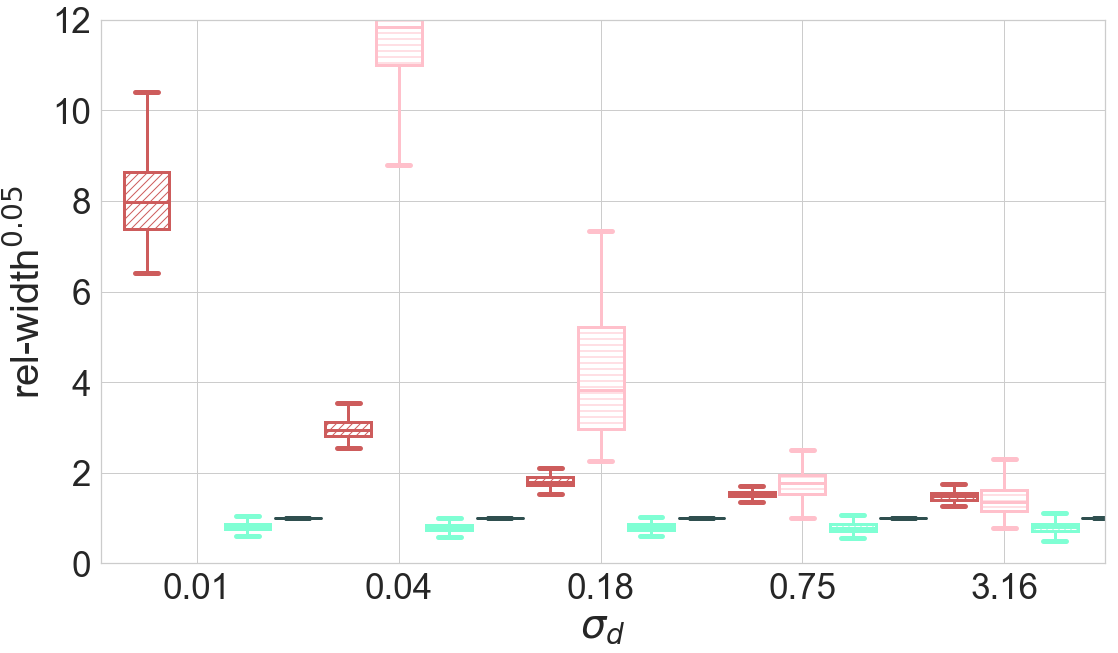

In [335]:
imp.reload(run_cis)
imp.reload(analysis)

save_paths = width_save_paths(dir_path, dataset_name, param_string, alpha)
title = r"Varying $\sigma_y$ (P=LN(ln(%.1f), $\sigma_d^2$), $n$=%s, $\rho$=%s, $\alpha$=%.2f, $\theta$=%.2f, $\mathcal{R}$=[%s, %s])" % (true_median, n, rho, alpha, granularity, range_center-range_scale, range_center+range_scale)
xlabel = r"$\sigma_y$"
xset = ['%.2f' % data_scale[i] for i in range(len(data_scale))]

run_indices = [1, 3, 8]
algs = [alg_index[i][0] for i in run_indices]
print(algs)
run_indices_names = [1, 3, 8, 9]
alg_names = [alg_index[i][1] for i in run_indices_names]
print(alg_names)
alg_colors = [colors[i] for i in run_indices_names]
alg_styles = [styles[i] for i in run_indices_names]

save_path = save_paths[5]
save=True
print(save_path)
plt = analysis.plotCIs(algs, dataset_name, title, xset, xlabel, alg_names,
          param_string=param_string, ratio=True, line_plot=False, box_plot=True,
          ylim=[0,12], legend=False, show_title=False, blackwhite=True,
          log=False, legend_out=False, xlim=None, sort='byParam', dataset_param=True, 
    save=save, save_path=save_path, colors=alg_colors, styles=alg_styles)